# **Trend fitting for Horn of Africa flood study**

Use scale fit with GMST and IOD as covariates

In [1]:
source("../wwa_model-fitting.R")

## **Modified code for multiple linear regression**


### **Model fitting**

In [2]:
ns_loglik <- function(pars, cov, x, dist, fittype) {

    effect <- rowSums(pars[grepl("alpha", names(pars))] * cov)
    
    # compute nonstationary location & scale
    if(fittype == "fixeddisp") {
        const = exp(effect / pars["mu0"])
        loc = pars["mu0"] * const
        scale = pars["sigma0"] * const
    } else if(fittype == "shift") {
        loc = pars["mu0"] + effect
        scale = pars["sigma0"]
    } else {
        print(paste(fittype, "not implemented"))
        return()
    }

    # constrain variance to be strictly positive
    if(any(scale <= 0)) return(NA)
        
    # return negative log-likelihood
    if(dist == "norm") {
        return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
    } else if(dist == "gev") {
        shape = pars["shape"]
        return(-sum(devd(x, loc = loc, scale = scale, shape = shape, log = T)))
    } else {
        print(paste(dist, "not implemented"))
        return()
    }
}

In [3]:
fit_ns <- function(dist, type = "fixeddisp", data, varnm, covnm, lower = F, mintemps = F, ev = NA, method = "BFGS", ...) {
    
    # currently only works for distributions fully specified by mean & sd: only tested for normal, lognormal
    if(! dist %in% c("norm", "gev")) {
        print("Not yet implemented: use norm or gev")
        return()
    }
    
    # add something here to automatically handle no covariates
    
    # if looking at minimum temperatures (or minima of negative values generally), need to flip data for stable model fitting
    x <- data[,varnm]; if(mintemps) x <- -x
    cov <- data[, covnm, drop = F]
    k <- length(covnm)
    
    # fit model with appropriate number of parameters, pad if necessary
    init <- c("mu0" = mean(x), "sigma0" = sd(x), setNames(rep(0,k), paste0("alpha_", covnm)))

    if(dist == "gev") init <- c(init, "shape" = 0)
    fitted <- suppressWarnings(optim(par = init, ns_loglik, cov = cov, x = x, dist = dist, fittype = type, method = method))
    
    # if looking at minimum temperatures (or minima of negative values generally), so trend & location parameters have been flipped. This may cause some confusion so may have to modify later!
    if(mintemps) {
        fitted[["NOTE"]] <- "NB: model parameters are estimated for negative values"
        fitted$par["mu0"] <- -fitted$par["mu0"]
        fitted$par[grepl("alpha", names(fitted$par))] <- -fitted$par[grepl("alpha", names(fitted$par))]
        x <- -x
    }
            
    # attach assorted useful information
    fitted[["dist"]] <- dist
    fitted[["type"]] <- type
    fitted[["varnm"]] <- varnm
    fitted[["covnm"]] <- covnm
    fitted[["data"]] <- data
    fitted[["x"]] <- x
    fitted[["cov"]] <- cov
    
    fitted[["lower"]] <- lower               # saves having to specify every time later on
    fitted[["mintemps"]] <- mintemps         # look at maxima of 0-temps, rather than minima of observed temps
    
    if(is.na(ev)) { ev <- x[length(x)] } # event value: assume that event of interest is most recent, unless told otherwise (used in later plotting functions)
    fitted[["ev"]] <- ev

    return(fitted)
}

In [4]:
refit <- function(mdl, new_df) {
    fit_ns(dist = mdl$dist, type = mdl$type, data = new_df, varnm = mdl$varnm, covnm = mdl$covnm, lower = mdl$lower, mintemps = mdl$mintemps, ev = mdl$ev)
}

### **Parameter estimates**

In [5]:
ns_pars <- function(mdl, fixed_cov = NA) {
    
    # if no covariate value given, evaluate at all covariate values
    if(is.na(unlist(fixed_cov)[1])) fixed_cov <- mdl$cov
    
    # calculate the nonstationary parameter values
    pars <- mdl$par
    
    effect <- rowSums(pars[grepl("alpha", names(pars)), drop = F] * fixed_cov)
    
    if(mdl$type == "fixeddisp") {
        
        ns_const = exp(effect / pars["mu0"])
        loc = pars["mu0"] * ns_const
        scale = pars["sigma0"] * ns_const
        
    } else if(mdl$type == "shift") {
        loc = pars["mu0"] + effect
        scale = rep(pars["sigma0"], length(loc))
    } else {
        print(paste(mdl$type,"not implemented"))
        return()
    }
        
    # return the list of named parameters: location, scale, shape (if applicable)
    if("shape" %in% names(pars)) {
        return(lapply(list("loc" = loc, "scale" = scale, "shape" = rep(pars["shape"], length(scale))), unname))
    } else {
        return(lapply(list("loc" = loc, "scale" = scale), unname))
    }
}

In [6]:
mdl_ests <- function(mdl) {
        
    pars <- mdl$par
    event_2023 <- mdl$ev
    
    cov_2023 = data.frame("gmst" = gmst_2023, "iod" = iod_2023)
    cov_hist = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023)
    cov_neut = data.frame("gmst" = gmst_2023, "iod" = 0)
    cov_neuthist = data.frame("gmst" = gmst_2023 - 1.2, "iod" = 0)

    rp_2023 <- return_period(mdl, event_2023, fixed_cov = cov_2023)
    rp_hist <- return_period(mdl, event_2023, fixed_cov = cov_hist)
    rp_neut <- return_period(mdl, event_2023, fixed_cov = cov_neut)
    rp_neuthist <- return_period(mdl, event_2023, fixed_cov = cov_neuthist)

    # hacky, but better than nothing - will give correct abs/relative value depending on fit type
    if(is.infinite(rp_2023)) rp_2023 <- 100

    rl_hist <- eff_return_level(rp_2023, mdl, cov_hist)
    rl_neut <- eff_return_level(rp_2023, mdl, cov_neut)
    rl_neuthist <- eff_return_level(rp_2023, mdl, cov_neuthist)

    pr_hist <- prob_ratio(mdl, event_2023, cov_2023, cov_hist)
    pr_neut <- prob_ratio(mdl, event_2023, cov_2023, cov_neut)
    pr_neuthist <- prob_ratio(mdl, event_2023, cov_2023, cov_neuthist)

    dI_hist <- int_change(mdl, rp_2023, cov_2023, cov_hist, rel = F)
    dI_neut <- int_change(mdl, rp_2023, cov_2023, cov_neut, rel = F)
    dI_neuthist <- int_change(mdl, rp_2023, cov_2023, cov_neuthist, rel = F)

    rdI_hist <- int_change(mdl, rp_2023, cov_2023, cov_hist, rel = T)
    rdI_neut <- int_change(mdl, rp_2023, cov_2023, cov_neut, rel = T)
    rdI_neuthist <- int_change(mdl, rp_2023, cov_2023, cov_neuthist, rel = T)

    lss <- ns_pars(mdl, fixed_cov = cov_2023)
    disp <- lss$scale / lss$loc
    
    rp_unc <- 1/(mean(sapply(df$iod[df$year >= 1980], function(i) {
        1/return_period(mdl, x = event_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = i))
    })))
    rp_unc_hist <- 1/(mean(sapply(df$iod[df$year >= 1980], function(i) {
        1/return_period(mdl, x = event_2023, fixed_cov = data.frame("gmst" = gmst_2023 - 1.2, "iod" = i))
    })))
    
    pr_unc <- rp_unc_hist / rp_unc
    
    c(pars, sapply(c("disp", "event_2023", "rl_hist", "rl_neut", "rl_neuthist", "dI_hist", "dI_neut", "dI_neuthist", "rdI_hist", "rdI_neut", 
                     "rdI_neuthist", "rp_2023", "rp_hist", "rp_neut", "rp_neuthist", "rp_unc", "pr_unc", "pr_hist", "pr_neut", "pr_neuthist"), 
                   get, envir = environment()))
}

In [7]:
boot_ci <- function(mdl, nsamp = 1000, seed = 42) {
    
    set.seed(seed)
    mdl_df <- mdl$data
    res <- sapply(1:nsamp, function(i) {
        # print(i)
        lres <- NA
        while(is.na(lres[1])) {
            boot_df <- mdl_df[sample(1:nrow(mdl_df), replace = T),]
            lres <- tryCatch({
                boot_mdl <- suppressWarnings(refit(mdl, boot_df))
                mdl_ests(boot_mdl)
            }, error = function(cond) {return(NA)})
        }
        lres
    })
    rbind("est" = mdl_ests(mdl), apply(res, 1, quantile, c(0.025, 0.975), na.rm = T))
}

In [8]:
cmdl_ests <- function(mdl, rp_2023 = 10) {
        
    pars <- mdl$par
    event_2023 <- mdl$ev
    
    cov_2023 = data.frame("gmst" = gmst_2023, "iod" = iod_2023)
    cov_hist = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023)
    cov_neut = data.frame("gmst" = gmst_2023, "iod" = 0)
    cov_neuthist = data.frame("gmst" = gmst_2023 - 1.2, "iod" = 0)

    # rp_2023 <- return_period(mdl, event_2023, fixed_cov = cov_2023)
    rp_hist <- return_period(mdl, event_2023, fixed_cov = cov_hist)
    rp_neut <- return_period(mdl, event_2023, fixed_cov = cov_neut)
    rp_neuthist <- return_period(mdl, event_2023, fixed_cov = cov_neuthist)

    # hacky, but better than nothing - will give correct abs/relative value depending on fit type
    # if(is.infinite(rp_2023)) rp_2023 <- 100

    rl_hist <- eff_return_level(rp_2023, mdl, cov_hist)
    rl_neut <- eff_return_level(rp_2023, mdl, cov_neut)
    rl_neuthist <- eff_return_level(rp_2023, mdl, cov_neuthist)

    pr_hist <- prob_ratio(mdl, event_2023, cov_2023, cov_hist)
    pr_neut <- prob_ratio(mdl, event_2023, cov_2023, cov_neut)
    pr_neuthist <- prob_ratio(mdl, event_2023, cov_2023, cov_neuthist)

    dI_hist <- int_change(mdl, rp_2023, cov_2023, cov_hist, rel = F)
    dI_neut <- int_change(mdl, rp_2023, cov_2023, cov_neut, rel = F)
    dI_neuthist <- int_change(mdl, rp_2023, cov_2023, cov_neuthist, rel = F)

    rdI_hist <- int_change(mdl, rp_2023, cov_2023, cov_hist, rel = T)
    rdI_neut <- int_change(mdl, rp_2023, cov_2023, cov_neut, rel = T)
    rdI_neuthist <- int_change(mdl, rp_2023, cov_2023, cov_neuthist, rel = T)

    lss <- ns_pars(mdl, fixed_cov = cov_2023)
    disp <- lss$scale / lss$loc
    
    rp_unc <- 1/(mean(sapply(df$iod[df$year >= 1980], function(i) {
        1/return_period(mdl, x = event_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = i))
    })))
    rp_unc_hist <- 1/(mean(sapply(df$iod[df$year >= 1980], function(i) {
        1/return_period(mdl, x = event_2023, fixed_cov = data.frame("gmst" = gmst_2023 - 1.2, "iod" = i))
    })))
    
    pr_unc <- rp_unc_hist / rp_unc
    
    c(pars, sapply(c("disp", "event_2023", "rl_hist", "rl_neut", "rl_neuthist", "dI_hist", "dI_neut", "dI_neuthist", "rdI_hist", "rdI_neut", 
                     "rdI_neuthist", "rp_2023", "rp_hist", "rp_neut", "rp_neuthist", "rp_unc", "pr_unc", "pr_hist", "pr_neut", "pr_neuthist"), 
                   get, envir = environment()))
}

In [9]:
cmdl_boot_ci <- function(mdl, rp = 10, nsamp = 1000, seed = 42) {
    
    set.seed(seed)
    mdl_df <- mdl$data
    res <- sapply(1:nsamp, function(i) {
        # print(i)
        lres <- NA
        while(is.na(lres[1])) {
            boot_df <- mdl_df[sample(1:nrow(mdl_df), replace = T),]
            lres <- tryCatch({
                boot_mdl <- suppressWarnings(refit(mdl, boot_df))
                cmdl_ests(boot_mdl, rp = rp)
            }, error = function(cond) {return(NA)})
        }
        lres
    })
    rbind("est" = cmdl_ests(mdl, rp = rp), apply(res, 1, quantile, c(0.025, 0.975), na.rm = T))
}

### **Plotting methods**

In [10]:
plot_returnlevels <- function(mdl, cov, cov_cf, ev, ylim = NA, pch = 20, ylab = NA, legend_pos = "topright", main = "", 
                              xlim = c(1,10000), legend_labels = c("Present climate", "Counterfactual climate"), seed = 42, nsamp = 500, ...) {
    
    x <- mdl$x
    if(missing(ev)) { ev <- mdl$ev }
    
    rp_x <- unique(c(seq(1.1,2,0.1), seq(2,100,1), seq(100,1000,10), seq(100,1000,100), seq(1000,10000,1000)))     # return periods at which to calculate values for curves
    rp_th <- 1/seq(1,0,length.out = length(x)+2)[2:(length(x)+1)]                                                  # quantiles to map against observations to check fit

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # calculate return periods & return levels
    
    rl_curve_pres <- map_from_u(1/rp_x, mdl, fixed_cov = cov)
    rl_curve_cf <- map_from_u(1/rp_x, mdl, fixed_cov = cov_cf)

    rl_obs_pres <- map_from_u(map_to_u(mdl), mdl, fixed_cov = cov)
    rl_obs_cf <- map_from_u(map_to_u(mdl), mdl, fixed_cov = cov_cf)

    rp_event_pres <- 1/map_to_u(mdl, ev, fixed_cov = cov)
    rp_event_cf <- 1/map_to_u(mdl, ev, fixed_cov = cov_cf)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # prep axes
    
    if(is.na(ylim[1])) { ylim <- range(pretty(c(x, rl_curve_pres, rl_curve_cf))) }
    if(is.na(ylab)) {ylab <- mdl$varnm}
    # if((substr(mdl$varnm,1,3) == "log") & (ylim[1] <= 0)) { ylim[1] <- 0.01 }
    
    # plot
    plot(0,type = "n", xlim = xlim, ylim = ylim, log = "x", xlab = "", ylab = "", main = main)
    mtext("Return period (years)", side = 1, line = 2.5, cex = par("cex"))
    mtext(ylab, side = 2, line = 2.5, cex = par("cex"))
    
    legend(legend_pos, legend = c(legend_labels, "Observed event"), col = c("firebrick", "blue", "magenta"), lty = 1, pch = c(pch,pch,NA), bty = "n")

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # return period curves
    lines(rp_x, rl_curve_pres, lwd = 2, col = "firebrick", lty = 1)       # present climate
    lines(rp_x, rl_curve_cf, lwd = 2, col = "blue", lty = 1)              # counterfactual
    
    # expected return periods vs return levels transformed to stationarity at that covariate value
    points(rp_th, sort(rl_obs_pres, decreasing = mdl$lower), col = "firebrick", pch = pch)      # present
    points(rp_th, sort(rl_obs_cf, decreasing = mdl$lower), col = "blue", pch = pch)             # counterfactual
    
    # horizontal line showing observed event, plus ticks showing return periods
    abline(h = ev, col = "magenta", lty = 2)
    suppressWarnings(rug(rp_event_pres, lwd = 3, col = "firebrick"))   # present
    suppressWarnings(rug(rp_event_cf, lwd = 3, col = "blue"))          # counterfactual
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Add confidence intervals to return periods
    
    if(!is.na(nsamp)) {
        x_ci <- c(5,10,20,50,100,200,500,1000,2000,5000,10000)
        set.seed(seed)

        mdl_df <- mdl$data[,c(mdl$varnm, mdl$covnm)]
        boot_res <- sapply(1:nsamp, function(i) {
            boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
            tryCatch({
                boot_mdl <- refit(mdl, boot_df)
                c(map_from_u(1/x_ci, boot_mdl, fixed_cov = cov), map_from_u(1/x_ci, boot_mdl, fixed_cov = cov_cf))
            }, error = function(cond) {return(rep(NA, length(x_ci)*2))})
        })
        est_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)
        
        # lines bounding confidence intervals
        # matplot(x_ci, t(est_ci[,1:length(x_ci)]), type = "l", lty = 1, lwd = 2, col = adjustcolor("firebrick", alpha = 0.3), add = T)
        # matplot(x_ci, t(est_ci[,-(1:length(x_ci))]), type = "l", lty = 1, lwd = 2, col = adjustcolor("blue", alpha = 0.3), add = T)
        
        # shaded region for confidence intervals
        polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,1:length(x_ci)], rev(est_ci[2,1:length(x_ci)])), density = NULL, border = NA, col = adjustcolor("firebrick", alpha = 0.1))
        polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,-(1:length(x_ci))], rev(est_ci[2,-(1:length(x_ci))])), density = NULL, border = NA, col = adjustcolor("blue", alpha = 0.1))
    }
}

In [27]:
plot_trend <- function(mdl, ev, ev_year, ylab = NA, legend_pos = "topleft", main = "", ylim = NA, lwd = 2, ...) {
    
    if(is.na(ylab)) {ylab <- mdl$varnm}
    if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }
    if(missing(ev)) { ev <- mdl$ev }
    if(missing(ev_year)) { ev_year <- mdl$data$year[which.min(abs(mdl$x - ev))] }
    
    plot(mdl$data$year, mdl$x, type = "S", lwd = lwd, col = adjustcolor("black", alpha = 1), xlab = "Year", ylab = ylab, main = main, ylim = ylim, ...)
    
    lines(mdl$data$year-0.5, ns_pars(mdl)$loc, col = adjustcolor("black", alpha = 0.5), lwd = lwd)
    matplot(mdl$data$year-0.5, eff_return_level(c(6,40), mdl), type = "l", lty = 1, add = T, col = adjustcolor("blue", alpha = 0.5), lwd = c(lwd, max(1,lwd -1)))
    
    points(ev_year-0.5, ev, col = "magenta", lwd = 2, pch = 0)
    
    # add legend
    legend(legend_pos, legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(lwd,lwd,max(1,lwd -1)))
}

In [24]:
plot_covtrend <- function(mdl, xcov, cov, cov_cf, fixed_cov = NA, ev, ylim = NA, xlab = NA, ylab = NA, 
                          legend_pos = "topleft", main = "", seed = 42, nsamp = 1000, lwd = 3) {

    if(is.na(xlab)) { xlab <- toupper(xcov)}
    if(is.na(ylab)) { ylab <- mdl$varnm}
    if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }
    if(missing(ev)) ev <- mdl$ev
    
    x <- mdl$cov[,xcov]
    o <- order(x)
    
    plot(x, mdl$x, pch = 20, main = main, xlab = "", ylab = "", ylim = ylim, xlim = range(c(x, cov[xcov], cov_cf[xcov])))
    mtext(xlab, side = 1, line = 2.5, cex = par("cex"))
    mtext(ylab, side = 2, line = 2.5, cex = par("cex"))
    
    points(cov[,xcov], ev, col = "magenta", lwd = 2, pch = 0)
    
    # trend lines
    lines(x[o], ns_pars(mdl, fixed_cov = fixed_cov)$loc[o], lwd = 3, col = "black", lty = 1)
    lines(x[o], eff_return_level(6, mdl, fixed_cov = fixed_cov)[o], col = "blue", lwd = 3, lty = 1)
    lines(x[o], eff_return_level(40, mdl, fixed_cov = fixed_cov)[o], col = "blue", lwd = 2, lty = 1)
    
    # # get confidence interval for mu'
    # mdl_df <- mdl$data
    # set.seed(seed)
    # mu_ci <- apply(sapply(1:nsamp, function(i) {
    #     boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
    #     tryCatch({
    #         boot_mdl <- refit(mdl, boot_df)
    #         c("mu_ev" = ns_pars(boot_mdl, fixed_cov = cov)$loc,
    #           "mu_cf" = ns_pars(boot_mdl, fixed_cov = cov_cf)$loc)
    #     }, error = function(cond) {return(rep(NA, 2))})
    # }), 1, quantile, c(0.025, 0.975), na.rm = T)
    
    # confidence interval & markers for mu' at factual & counterfactual covariates
    # lines(rep(cov[,xcov], 3), c(ns_pars(mdl, fixed_cov = cov)$loc, mu_ci[,"mu_ev"]), col = "black", lwd = 2, type = "o", pch = "_")
    # lines(rep(cov_cf[,xcov], 3), c(ns_pars(mdl, fixed_cov = cov_cf)$loc, mu_ci[,"mu_cf"]), col = "black", lwd = 2, type = "o", pch = "_")
    
    # add legend
    legend(legend_pos, legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(2,2,1))
}

---
# **Scale fit - GMST + IOD**

## **Observations**

In [ ]:
cov_lag <- "SON"

gmst <- load_ts("ts/gmst.dat", col.names = c("year", "gmst"))
iod <- load_ts(paste0("ts/iod_", toupper(cov_lag), ".dat"), col.names = c("year", "iod"))
nino <- load_ts(paste0("ts/nino3.4-detrended_", toupper(cov_lag), ".dat"), col.names = c("year", "nino34"))

gmst_2023 <- gmst$gmst[gmst$year == 2023]
iod_2023 <- iod$iod[iod$year == 2023]

### **Fitted model**

In [28]:
# hangs if run within sapply loop so will set datasets & variables separately
dataset <- "cpc"; varnm <- "rx3day"
             
ts <- merge(load_ts(paste0("ts/HoA-flooding_", dataset, "_OND_rx3day.dat"), col.names = c("year", "rx3day")),
            load_ts(paste0("ts/HoA-flooding_", dataset, "_OND_rx30day_mean.dat"), col.names = c("year", "rx30day")))

df <- merge(merge(merge(gmst, iod), nino), ts)

mdl_fd <- fit_ns("gev", "fixeddisp", df, varnm, c("gmst", "iod"))
res <- boot_ci(mdl_fd)

write.csv(res, paste0("res/res-obs_gmst-iod_", varnm, "_", dataset, "_", cov_lag, ".csv"))

In [ ]:
# compile results into a single file
incl <- c("disp", "shape", "event_2023", "rp_2023", "rp_unc", "pr_hist", "pr_neut", "dI_hist", "dI_neut", "rdI_hist", "rdI_neut")
res_compiled <- t(sapply(list.files("res", pattern = "res-obs_gmst-iod_", full.names = T), function(fnm) setNames(unlist(c(read.csv(fnm)[,incl])), paste0(rep(incl, each = 3), c("_est", "_lower", "_upper")))))
rownames(res_compiled) <- sapply(rownames(res_compiled), function(s) paste0(strsplit(s, "_")[[1]][3:4], collapse = "_"))
write.csv(res_compiled, "res/res-obs_gmst-iod.csv")

### **Plots of fitted models**

In [45]:
cov_lag <- "SON"

gmst <- load_ts("ts/gmst.dat", col.names = c("year", "gmst"))
iod <- load_ts(paste0("ts/iod_", toupper(cov_lag), ".dat"), col.names = c("year", "iod"))
nino <- load_ts(paste0("ts/nino3.4-detrended_", toupper(cov_lag), ".dat"), col.names = c("year", "nino34"))

gmst_2023 <- gmst$gmst[gmst$year == 2023]
iod_2023 <- iod$iod[iod$year == 2023]

In [46]:
varnm <- "rx3day"

df_mswep <- merge(merge(merge(gmst, iod), nino), load_ts(list.files("ts", pattern = paste0("mswep.+",varnm), full.names = T), col.names = c("year", varnm)))
df_tamsat <- merge(merge(merge(gmst, iod), nino), load_ts(list.files("ts", pattern = paste0("tamsat.+",varnm), full.names = T), col.names = c("year", varnm)))
df_cpc <- merge(merge(merge(gmst, iod), nino), load_ts(list.files("ts", pattern = paste0("cpc.+",varnm), full.names = T), col.names = c("year", varnm)))

if(varnm == "rx30day") {
    df_mswep$rx30day <- df_mswep$rx30day * 30
    df_tamsat$rx30day <- df_tamsat$rx30day * 30
}

mdl_mswep <- fit_ns("gev", "fixeddisp", df_mswep, varnm, c("gmst", "iod"))
mdl_tamsat <- fit_ns("gev", "fixeddisp", df_tamsat, varnm, c("gmst", "iod"))
mdl_cpc <- fit_ns("gev", "fixeddisp", df_cpc, varnm, c("gmst", "iod"))

gmst_2023 <- df_mswep$gmst[df_mswep$year == 2023]
iod_2023 <- df_mswep$iod[df_mswep$year == 2023]
iod_clim <- mean(df_mswep$iod[(df_mswep$year >= 1990) & (df_mswep$year <= 2020)])
gmst_clim <- mean(df_mswep$gmst[(df_mswep$year >= 1990) & (df_mswep$year <= 2020)])

if(varnm == "rx3day") { yl <- c(0,120) } else { yl <- c(0,450) }

In [50]:
prep_window(c(1,4)); par(mfrow = c(1,3))

png(paste0("fig/",varnm,"_trend-vs-time.png"), height = 480, width = 480 * 4); par(mfrow = c(1,3), cex = 1.4); {
    plot_trend(mdl_mswep, main = "MSWEP", xlim = c(1979, 2023), ylim = yl, lwd = 4)
    plot_trend(mdl_tamsat, main = "TAMSAT", xlim = c(1979, 2023), ylim = yl, lwd = 4)
    plot_trend(mdl_cpc, main = "CPC", xlim = c(1979, 2023), ylim = yl, lwd = 4)
}; dev.off()

png 
  2

In [51]:
prep_window(c(1,4)); par(mfrow = c(1,3))

png(paste0("fig/",varnm,"_trend-vs-gmst.png"), height = 480, width = 480 * 4); par(mfrow = c(1,3), cex = 1.4); {
    plot_covtrend(mdl_mswep, xcov = "gmst", cov = data.frame("gmst" = gmst_2023, "iod" = 0), cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = 0), 
                  ylim = yl, nsamp = 10, fixed_cov = cbind(df_mswep[,c("gmst")], iod_clim), main = "MSWEP")
    plot_covtrend(mdl_tamsat, xcov = "gmst", cov = data.frame("gmst" = gmst_2023, "iod" = 0), cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = 0), 
                      ylim = yl, nsamp = 10, fixed_cov = cbind(df_tamsat[,c("gmst")], iod_clim), main = "TAMSAT")
    plot_covtrend(mdl_cpc, xcov = "gmst", cov = data.frame("gmst" = gmst_2023, "iod" = 0), cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = 0), 
                      ylim = yl, nsamp = 10, fixed_cov = cbind(df_cpc[,c("gmst")], iod_clim), main = "CPC")
}; dev.off()

png 
  2

In [52]:
prep_window(c(1,4)); par(mfrow = c(1,3))

png(paste0("fig/", varnm, "_trend-vs-iod.png"), height = 480, width = 480 * 4); par(mfrow = c(1,3), cex = 1.4); {
    plot_covtrend(mdl_mswep, xcov = "iod", cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0), 
                  ylim = yl, nsamp = 10, fixed_cov = cbind(gmst_clim, df_mswep[,c("iod")]), main = "MSWEP")
    plot_covtrend(mdl_tamsat, xcov = "iod", cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0), 
                      ylim = yl, nsamp = 10, fixed_cov = cbind(gmst_clim, df_tamsat[,c("iod")]), main = "TAMSAT")
    plot_covtrend(mdl_cpc, xcov = "iod", cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0), 
                      ylim = yl, nsamp = 10, fixed_cov = cbind(gmst_clim, df_cpc[,c("iod")]), main = "CPC")
}; dev.off()

png 
  2

In [53]:
prep_window(c(1,4)); par(mfrow = c(1,3))

png(paste0("fig/", varnm, "_returnlevels.png"), height = 480, width = 480 * 4); par(mfrow = c(1,3), cex = 1.4); {
    plot_returnlevels(mdl_mswep, cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023),
                      main = "MSWEP", ylim = yl, legend_pos = "topleft")
    # points(1/seq(1,0,length.out = nrow(df_mswep)+2)[2:(nrow(df_mswep)+1)], sort(df_mswep$rx3day), pch = 20, col = adjustcolor("black", 0.5))
    plot_returnlevels(mdl_tamsat, cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023),
                      main = "TAMSAT", ylim = yl, legend_pos = "topleft")
    # points(1/seq(1,0,length.out = nrow(df_tamsat)+2)[2:(nrow(df_tamsat)+1)], sort(df_tamsat$rx3day), pch = 20, col = adjustcolor("black", 0.5))
    plot_returnlevels(mdl_cpc, cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023),
                      main = "CPC", ylim = yl, legend_pos = "topleft")
    # points(1/seq(1,0,length.out = nrow(df_cpc)+2)[2:(nrow(df_cpc)+1)], sort(df_cpc$rx3day), pch = 20, col = adjustcolor("black", 0.5))
}; dev.off()

png 
  2

### **Fitted model including ENSO**

In [33]:
# hangs if run within sapply loop so will set datasets & variables separately
dataset <- "mswep"; varnm <- "rx30day"
             
ts <- merge(load_ts(paste0("ts/HoA-flooding_", dataset, "_OND_rx3day.dat"), col.names = c("year", "rx3day")),
            load_ts(paste0("ts/HoA-flooding_", dataset, "_OND_30day_mean.dat"), col.names = c("year", "rx30day")))

df <- merge(merge(merge(gmst, iod), nino), ts)

mdl_fd <- fit_ns("gev", "fixeddisp", df, varnm, c("gmst", "iod", "nino34"))
res <- boot_ci(mdl_fd)

write.csv(res, paste0("res/res-obs_gmst-iod-enso_", varnm, "_", dataset, "_", cov_lag, ".csv"))

In [63]:
nino_2023 <- df$nino34[df$year == 2023]
nino_clim <- mean(df$nino34)
gmst_clim <- mean(df$gmst)
iod_clim <- mean(df$iod)

yl <- c(0,12)

In [76]:
mdl_nino <- fit_ns("gev", "fixeddisp", df, varnm, c("gmst", "iod", "nino34"))
mdl_iod <- fit_ns("gev", "fixeddisp", df, varnm, c("gmst", "iod"))

prep_window(c(1,4)); par(mfrow = c(1,2))

plot_trend(mdl_iod, main = "GMST + IOD", xlim = c(1979, 2023), ylim = c(0,15))
plot_trend(mdl_nino, main = "GMST + IOD + NINO34", xlim = c(1979, 2023), ylim = c(0,15))

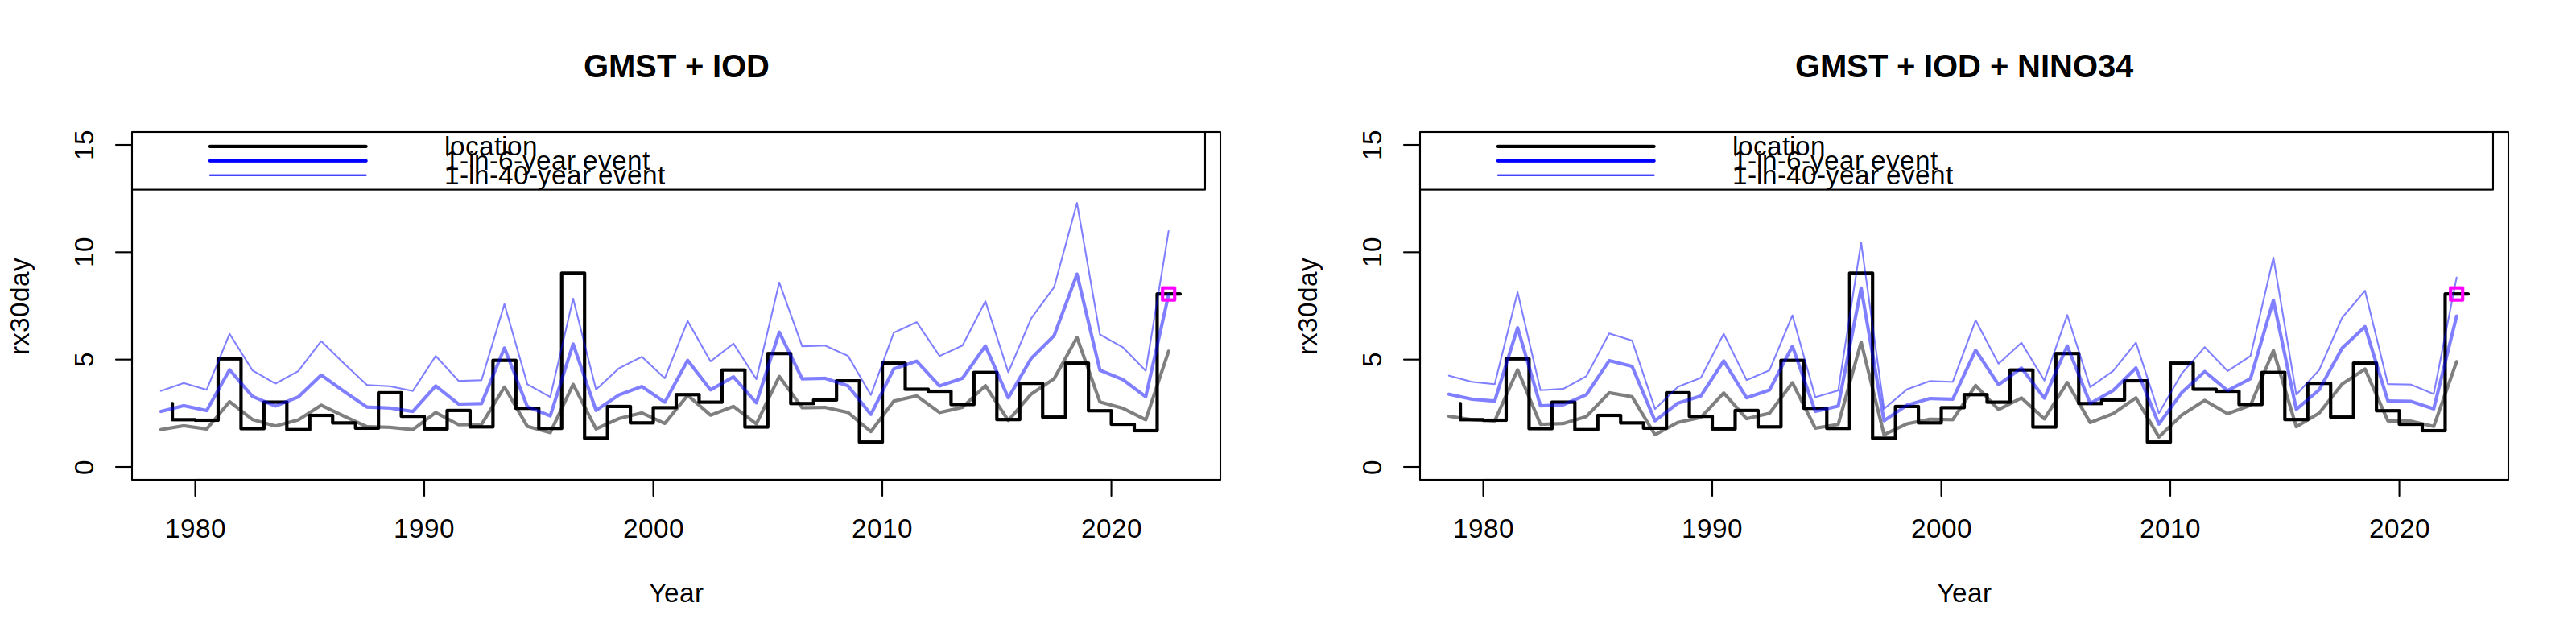

In [85]:
prep_window(c(1,4)); par(mfrow = c(1,2))

plot_covtrend(mdl_iod, xcov = "gmst", ylim = yl, nsamp = 10, main = "MSWEP", 
              cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
              cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023), 
              fixed_cov = cbind(df[,c("gmst")], iod_clim))
lines(df$gmst[order(df$gmst)], ns_pars(mdl_nino, fixed_cov = cbind(df[,c("gmst")], iod_clim, nino_clim))$loc[order(df$gmst)], col = "red", lwd = 2)

plot_covtrend(mdl_nino, xcov = "gmst", ylim = yl, nsamp = 10, main = "MSWEP", 
              cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023), 
              cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023, "nino34" = nino_2023), 
              fixed_cov = cbind(df[,c("gmst")], iod_clim, nino_clim))
lines(df$gmst[order(df$gmst)], ns_pars(mdl_iod, fixed_cov = cbind(df[,c("gmst")], iod_clim))$loc[order(df$gmst)], col = "red", lwd = 2)

In [95]:
int_change(mdl_iod, rp = 10, cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023),
           cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023), relative = T)

int_change(mdl_nino, rp = 10, cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023),
           cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023, "nino34" = nino_2023), relative = T)

[1] 87.31152

[1] 38.10437

In [75]:
# quick AIC check
2*4 + 2*mdl_iod$value
2*5 + 2*mdl_nino$value

[1] 122.3166

[1] 119.4003

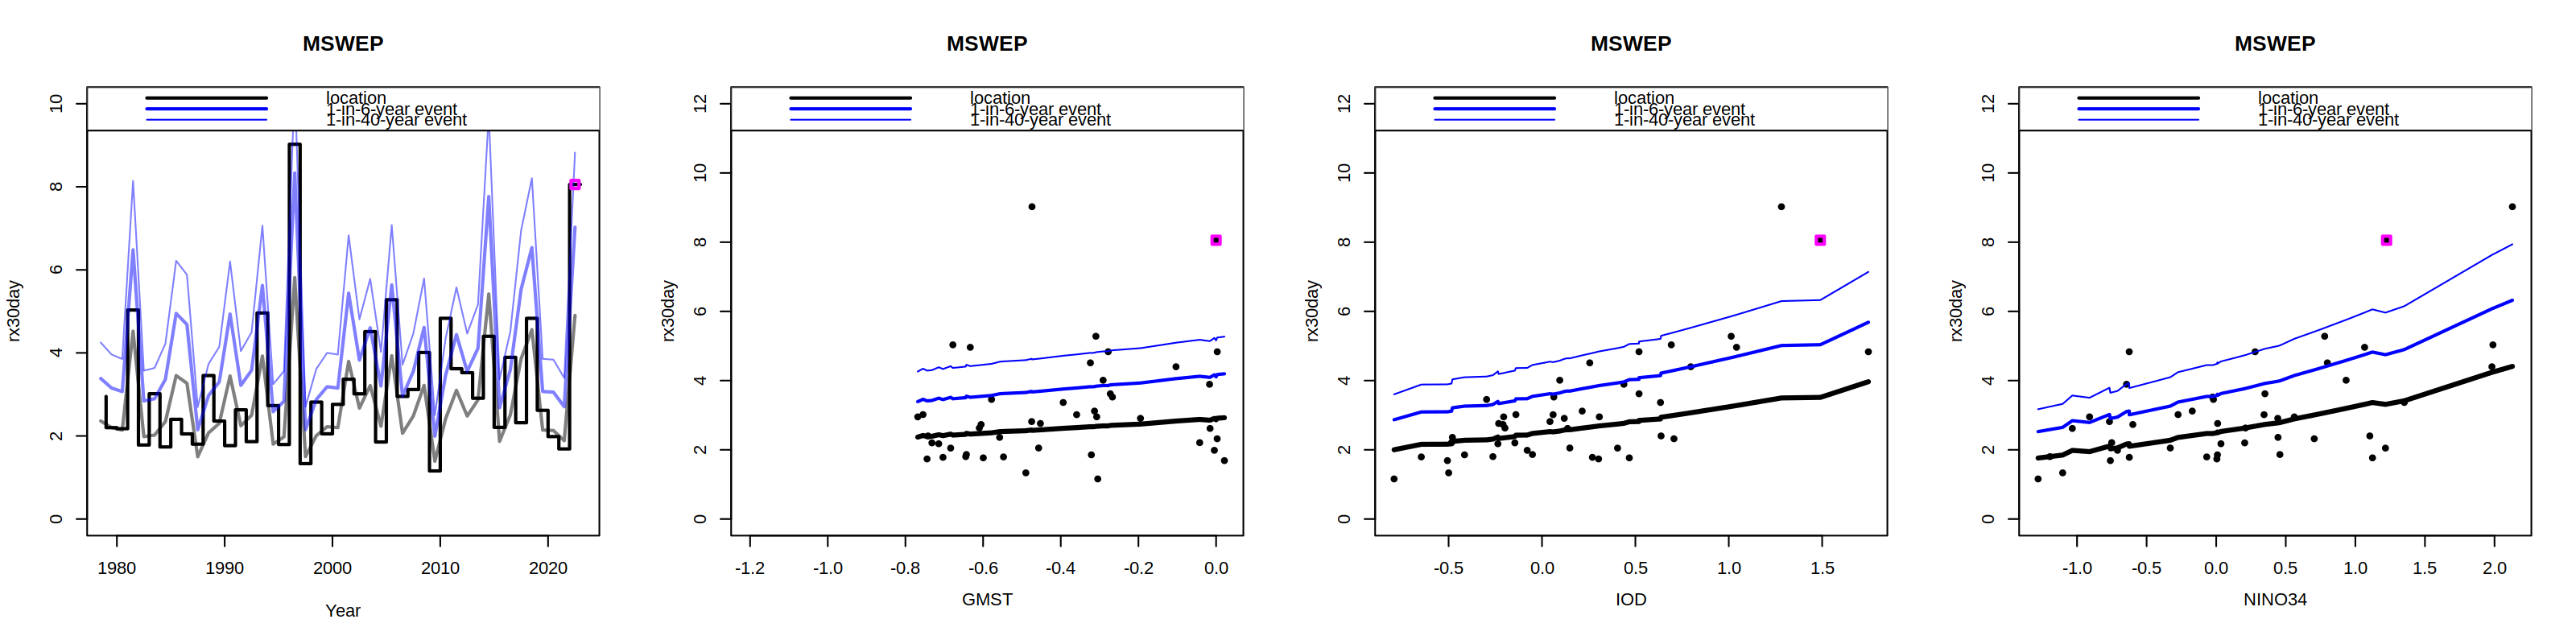

In [66]:
prep_window(c(1,4))

plot_trend(mdl_nino, main = "MSWEP", xlim = c(1979, 2023))

plot_covtrend(mdl_nino, xcov = "gmst", ylim = yl, nsamp = 10, main = "MSWEP", 
              cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023), 
              cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023, "nino34" = nino_2023), 
              fixed_cov = cbind(df[,c("gmst")], iod_clim, nino_clim))

plot_covtrend(mdl_nino, xcov = "iod", ylim = yl, nsamp = 10, main = "MSWEP", 
              cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023), 
              cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0, "nino34" = nino_2023), 
              fixed_cov = cbind(gmst_clim, df[,c("iod")], nino_clim))

plot_covtrend(mdl_nino, xcov = "nino34", ylim = yl, nsamp = 10, main = "MSWEP", 
              cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = nino_2023), 
              cov_cf = data.frame("gmst" = gmst_2023, "iod" = iod_2023, "nino34" = 0), 
              fixed_cov = cbind(gmst_clim, iod_clim, df[,c("nino34")]))

In [20]:
# compile results into a single file
incl <- c("disp", "shape", "event_2023", "rp_2023", "rp_unc", "pr_hist", "pr_neut", "dI_hist", "dI_neut", "rdI_hist", "rdI_neut")
res_compiled <- t(sapply(list.files("res", pattern = "res-obs_gmst-iod_", full.names = T), function(fnm) setNames(unlist(c(read.csv(fnm)[,incl])), paste0(rep(incl, each = 3), c("_est", "_lower", "_upper")))))
rownames(res_compiled) <- sapply(rownames(res_compiled), function(s) paste0(strsplit(s, "_")[[1]][3:4], collapse = "_"))
write.csv(res_compiled, "res/res-obs_gmst-iod.csv")


### **Properties of IOD for validation**

In [ ]:
iod_ts <- iod$iod

set.seed(42)
iod_ci <- sapply(1:1000, function(i) {
    iod_boot <- sample(iod_ts, replace = T)
    c("mean" = mean(iod_boot), "sd" = sd(iod_boot))
})
t(rbind("est" = c("mean" = mean(iod_ts), "sd" = sd(iod_ts)), apply(iod_ci, 1, quantile, c(0.05, 0.95))))

,est,5%,95%
mean,0.002921575,-0.06370119,0.0669238
sd,0.512850929,0.44919538,0.5754951


In [23]:
iod <- load_ts("ts/iod_SON.dat", col.names = c("year", "iod"))
iod_df <- list()
               
iod_df <- t(sapply(c("mswep", "tamsat", "cpc"), function(ds) {
    
    rx30day <- load_ts(paste0("ts/HoA-flooding_", ds, "_OND_30day_mean.dat"), col.names = c("year", "rx30day"))
    df <- merge(iod, rx30day)
    
    set.seed(42)
    iod_ci <- sapply(1:1000, function(i) {
        iod_boot <- df[sample(nrow(df), replace = T),]
        cor(iod_boot$iod, iod_boot$rx30day)
    })
    iod_df[[ds]] <- c("est" = cor(df$iod, df$rx30day), quantile(iod_ci, c(0.025, 0.975)))
}))
write.csv(iod_df, "res/res-obs_iod.csv")

,est,2.5%,97.5%
mswep,0.7458903,0.5923705,0.8529405
tamsat,0.7665630,0.5458827,0.8792467
cpc,0.6603410,0.4180734,0.7943654


---
## **Climate models**

In [6]:
# tailored code for climate model results

### **CORDEX**

In [281]:
# list of models without covariates/that failed to converge for historical data
excl <- c("ts/cordex/rx3day-ond_HoA_AFR-44_MPI-ESM-MR_r1i1p1_ICTP-RegCM4-3.dat",
          "ts/cordex/rx3day-ond_HoA_AFR-44_EC-EARTH_r12i1p1_CLMcom-CCLM4-8-17.dat",
          "ts/cordex/rx3day-ond_HoA_AFR-44_EC-EARTH_r12i1p1_KNMI-RACMO22T.dat",
          "ts/cordex/rx3day-ond_HoA_AFR-44_EC-EARTH_r12i1p1_MPI-CSC-REMO2009.dat",
          "ts/cordex/rx3day-ond_HoA_AFR-44_EC-EARTH_r3i1p1_DMI-HIRHAM5.dat",
          "ts/cordex/rx3day-ond_HoA_AFR-44_GFDL-ESM2G_r1i1p1_GERICS-REMO2009.dat",
          "ts/cordex/rx3day-ond_HoA_AFR-44_HadGEM2-ES_r1i1p1_ICTP-RegCM4-3.dat",
          "ts/cordex/rx3day-ond_HoA_AFR-44_CM5A-LR_r1i1p1_GERICS-REMO2009.dat",
          "ts/cordex/rx3day-ond_HoA_AFR-44_EC-EARTH_r1i1p1_KNMI-RACMO22T.dat")

fl <- list.files("ts/cordex", pattern = "rx3day-ond", full.names = T)
fl <- unlist(unname(sapply(fl, function(fnm) {
    res_fnm <- paste0("res/res-cordex_rx3day_", paste0(gsub(".dat","",strsplit(fnm, "_")[[1]][3:6]), collapse = "_"), "_hist.csv")
    if(file.exists(res_fnm)) { return(NULL) } else {return(fnm) }
})))
fl <- unlist(unname(sapply(fl, function(fnm) {
    if(fnm %in% excl) { return(NULL) } else {return(fnm)}
})))
fl

[1] "ts/cordex/rx3day-ond_HoA_AFR-44_MPI-ESM-LR_r1i1p1_CLMcom-CCLM4-8-17.dat"

In [283]:
fnm = fl[1]

res_fnm <- paste0("res/res-cordex_gmst-iod_rx3day_", paste0(gsub(".dat","",strsplit(fnm, "_")[[1]][3:6]), collapse = "_"), "_hist.csv")
print(fnm)
# print(res_fnm)

if(!file.exists(res_fnm)) {
    gcm <- strsplit(fnm, "_")[[1]][4]

    gmst_fnm <- list.files("ts/gmst", pattern = paste0("cmip5.+", strsplit(fnm, "_")[[1]][4], ".+", substr(strsplit(fnm, "_")[[1]][5],1,2)), full.names = T)
    iod_fnm <- list.files("ts/iod", pattern = paste0("cmip5_", strsplit(fnm, "_")[[1]][4], "_", substr(strsplit(fnm, "_")[[1]][5],2,2)), full.names = T)
    
    if((length(gmst_fnm) == 0) | (length(iod_fnm) == 0)) {
        if(length(gmst_fnm) == 0) print("No GMST")
        if(length(iod_fnm) == 0) print("No IOD")
    } else {
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        if(max(ts) < 1) {ts$pr <- ts$pr * 86400}
        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        iod <- load_ts(iod_fnm, col.names = c("year", "iod"))

        df <- merge(merge(gmst, iod), ts)
        df <- df[df$year <= 2023,]
                    
        mdl_fd <- tryCatch({
            fit_ns("gev", "fixeddisp", df, "pr", c("gmst", "iod"))
        }, error = function(cond) {return(NULL)})
        if(is.null(mdl_fd)) {
            print("Model fitting failed")
        } else {
            res <- cmdl_boot_ci(mdl_fd, rp = 5)
            write.csv(res, res_fnm)
            print("done.")
        }
    }
}

[1] "ts/cordex/rx3day-ond_HoA_AFR-44_MPI-ESM-LR_r1i1p1_CLMcom-CCLM4-8-17.dat"
[1] "done."


In [284]:
# compile results into a single file
incl <- c("disp", "shape", "event_2023", "rp_2023", "rp_unc", "pr_hist", "pr_neut", "dI_hist", "dI_neut", "rdI_hist", "rdI_neut")
res_compiled <- t(sapply(list.files("res", pattern = "res-cordex_rx3day.+hist", full.names = T), function(fnm) setNames(unlist(c(read.csv(fnm)[,incl])), paste0(rep(incl, each = 3), c("_est", "_lower", "_upper")))))
rownames(res_compiled) <- sapply(rownames(res_compiled), function(s) paste0(strsplit(s, "_")[[1]][3:6], collapse = "_"))
write.csv(res_compiled, "res/res-cordex_gmst-iod.csv")

#### **IOD characteristics**

In [19]:
res_fl <- list.files("res", pattern = "res-cordex_gmst-iod_rx3day.+hist", full.names = T)
iod_df <- list()
for (res_fnm in res_fl) {
    
    fnm <- list.files("ts/cordex", pattern = paste0("rx3day.+", paste0(strsplit(res_fnm, "_")[[1]][3:6], collapse = "_")), full.names = T)
    iod_fnm <- list.files("ts/iod", pattern = paste0("cmip5_", strsplit(fnm, "_")[[1]][4], "_", substr(strsplit(fnm, "_")[[1]][5],2,2)), full.names = T)
    
    iod <- load_ts(iod_fnm, col.names = c("year", "iod"))
    rx3day <- load_ts(fnm, col.names = c("year", "rx3day"))
    
    fnm_30d <- gsub("_r1i1p1", "", gsub("3day", "30day", fnm))
    if(file.exists(fnm_30d)) {
        rx30day <- load_ts(fnm_30d, col.names = c("year", "rx30day"))
    } else {
        rx30day <- data.frame(year = rx3day$year, rx30day = NA)
    }
    df <- merge(iod, merge(rx3day, rx30day))
     
    z <- unlist(sapply(c(2023, 2050), function(y) {
        df_y <- df[df$year <= y,]
        
        setNames(c(mean(df_y$iod), sd(df_y$iod), cor(df_y$iod, df_y$rx3day), cor(df_y$iod, df_y$rx30day)),
                 paste0(c("iod_mean", "iod_sd", "iod_rx3d", "iod_rx30d"), "_", y))
    }, simplify = F))
    iod_df[[paste0(strsplit(res_fnm, "_")[[1]][3:6], collapse = "_")]] <- z
}
iod_df <- t(data.frame(iod_df))
write.csv(iod_df, "res/res-cordex_iod.csv")

[1] "ts/cordex/rx30day-ond_HoA_AFR-44_IPSL-CM5A-LR_GERICS-REMO2009.dat"


### **HighResMIP**

In [117]:
varnm <- "rx3day"

iod <- load_ts("ts/iod_SON.dat", col.names = c("year", "iod"))
gmst <- load_ts("ts/gmst.dat", col.names = c("year", "gmst"))

gmst_2023 <- gmst$gmst[gmst$year == 2023]
iod_2023 <- iod$iod[iod$year == 2023]

# list of models that stop before 2023
excl <- c('BCC-CSM2-HR','CAMS-CSM1-0','ECMWF-IFS-HR','ECMWF-IFS-LR','FGOALS-f3-H','FGOALS-f3-L','INM-CM5-H',
          'IPSL-CM6A-ATM-HR','IPSL-CM6A-LR','NICAM16-9S')

fl <- list.files("ts/highresmip", pattern = paste0(varnm, "-ond"), full.names = T)
fl <- unlist(unname(sapply(fl, function(fnm) {
    res_fnm <- paste0("res/res-highresmip_gmst-iod_",varnm,"_", paste0(gsub(".dat","",strsplit(fnm, "_")[[1]][3]), collapse = "_"), "_hist.csv")
    if(file.exists(res_fnm)) { return(NULL) } else {return(fnm) }
})))
fl <- unlist(unname(sapply(fl, function(fnm) {
    if(gsub(".dat", "", strsplit(fnm, "_")[[1]][3]) %in% excl) { return(NULL) } else { return(fnm) }
})))
fl

NULL

In [199]:
nsamp <- 500
rp <- 5

for(fnm in fl) {


    print(fnm)
    res_fnm <- paste0("res/res-highresmip_gmst-iod_rx30day_", paste0(gsub(".dat","",strsplit(fnm, "_")[[1]][3]), collapse = "_"), "_hist.csv")

    if(!file.exists(res_fnm)) {

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        if(max(ts) < 1) {ts$pr <- ts$pr * 86400}

        df <- merge(merge(gmst, iod), ts)
        df <- df[df$year <= 2023,]

        mdl_fd <- tryCatch({
            fit_ns("gev", "fixeddisp", df, "pr", c("gmst", "iod"))
        }, error = function(cond) {return(NULL)})

        if(is.null(mdl_fd)) {
            print("Model fitting failed")
        } else {
            set.seed(42)
            res <- sapply(1:nsamp, function(i) {
                # print(i)
                # lres <- NA
                # while(is.na(lres[1])) {
                    boot_df <- df[sample(1:nrow(df), replace = T),]
                    lres <- tryCatch({
                        boot_mdl <- suppressWarnings(refit(mdl_fd, boot_df))
                        cmdl_ests(boot_mdl, rp = rp)
                    }, error = function(cond) {return(rep(NA, 25))})
                # }
                lres
            })
            res <- rbind("est" = cmdl_ests(mdl_fd, rp = rp),
                         apply(res, 1, quantile, c(0.025, 0.975), na.rm = T), 
                         "nmissing" = sum(is.na(res["mu0",])))
            # # res <- cmdl_boot_ci(mdl_fd, rp = 5, nsamp = 5)
            write.csv(res, res_fnm)
            # print("done.")
        }
    }
}

In [167]:
# compile results into a single file
incl <- c("disp", "shape", "event_2023", "rp_2023", "rp_unc", "pr_hist", "pr_neut", "dI_hist", "dI_neut", "rdI_hist", "rdI_neut")
res_compiled <- t(sapply(list.files("res", pattern = paste0("res-highresmip_gmst-iod_",varnm,".+hist"), full.names = T), 
                         function(fnm) setNames(unlist(c(read.csv(fnm)[1:3,incl])), paste0(rep(incl, each = 3), c("_est", "_lower", "_upper")))))
rownames(res_compiled) <- sapply(rownames(res_compiled), function(s) paste0(strsplit(s, "_")[[1]][4], collapse = "_"))
write.csv(res_compiled, paste0("res/res-highresmip_gmst-iod_",varnm,".csv"))

#### **IOD characteristics**

In [260]:
fl <- list.files("ts/highresmip", pattern = "rx3day", full.names = T)
iod <- load_ts("ts/iod_SON.dat", col.names = c("year", "iod"))
iod_df <- list()

for (fnm in fl) {
    
    rx3day <- load_ts(fnm, col.names = c("year", "rx3day"))
    if(file.exists(gsub("3day", "30day", fnm))) {
        rx30day <- load_ts(gsub("3day", "30day", fnm), col.names = c("year", "rx30day"))
    } else {
        rx30day <- data.frame(year = rx3day$year, rx30day = NA)
    }
    df <- merge(iod, merge(rx3day, rx30day))
     
    z <- c(min_yr = min(df$year), max_yr = max(df$year), unlist(sapply(c(2023, 2050), function(y) {
        df_y <- df[df$year <= y,]
        
        setNames(c(cor(df_y$iod, df_y$rx3day), cor(df_y$iod, df_y$rx30day)),
                 paste0(c("iod_rx3d", "iod_rx30d"), "_", y))
    }, simplify = F)))
    iod_df[[paste0(strsplit(fnm, "_")[[1]][3], collapse = "_")]] <- z
}
rn <- gsub(".dat", "", names(iod_df))
iod_df <- plyr::rbind.fill(lapply(lapply(iod_df, t), data.frame))
rownames(iod_df) <- rn
write.csv(iod_df, "res/res-highresmip_iod.csv")

### **CMIP6**

#### **IOD characteristics**

In [263]:
fl <- list.files("ts/cmip6", pattern = "rx3day", full.names = T)
iod_df <- list()

for ( fnm in fl ) {
    
    rx3day <- load_ts(fnm, col.names = c("year", "rx3day"))

    iod_fnm <- list.files("ts/iod", pattern = paste0("cmip6_", gsub(".dat", "", strsplit(fnm, "_")[[1]][3]), "_"), full.names = T)
    
    if(length(iod_fnm) == 0) {
        z <- setNames(rep(NA, 8), paste0(c("iod_mean", "iod_sd", "iod_rx3d", "iod_rx30d"), "_", rep(c(2023, 2050), each = 4)))
    } else {
        iod <- load_ts(iod_fnm, col.names = c("year", "iod"))

        fnm_30d <- gsub("3day", "30day", fnm)
        if(file.exists(fnm_30d)) {
            rx30day <- load_ts(fnm_30d, col.names = c("year", "rx30day"))
        } else {
            rx30day <- data.frame(year = rx3day$year, rx30day = NA)
        }
        
        df <- merge(iod, merge(rx3day, rx30day))
        
        z <- unlist(sapply(c(2023, 2050), function(y) {
            df_y <- df[df$year <= y,]

            setNames(c(mean(df_y$iod), sd(df_y$iod), cor(df_y$iod, df_y$rx3day), cor(df_y$iod, df_y$rx30day)),
                     paste0(c("iod_mean", "iod_sd", "iod_rx3d", "iod_rx30d"), "_", y))
        }, simplify = F))
    }
    iod_df[[paste0(strsplit(fnm, "_")[[1]][3], collapse = "_")]] <- z
}

rn <- gsub(".dat", "", names(iod_df))
iod_df <- plyr::rbind.fill(lapply(lapply(iod_df, t), data.frame))
rownames(iod_df) <- rn
write.csv(iod_df, "res/res-cmip6_iod.csv")

#### **Fitted models**

In [107]:
# identify models for which we have IOD
ml <- read.csv("res/res-cmip6_iod.csv", row.names = "X")
ml <- rownames(ml)[!is.na(ml$iod_mean_2023)]

ml <- c("CMCC-CM2-SR5", "CMCC-ESM2", "GFDL-CM4", "GFDL-ESM4", "NorESM2-MM")[3:5]
varnm <- "rx30day"
rp <- 30

ymax <- 2050

In [109]:
for ( mdl in ml ) {
    
    res_fnm <- paste0("res/res-cmip6_gmst-iod_", varnm, "_", mdl, "_",ymax,".csv")
    
    if(!file.exists(res_fnm)) {
        
        fnm <- list.files("ts/cmip6", pattern = paste0(varnm, ".+", mdl, ".dat"), full.names = T)
        gmst_fnm <- list.files("ts/gmst", pattern = paste0("SGSAT.+", mdl, "_"), full.names = T)
        iod_fnm <- list.files("ts/iod", pattern = paste0("cmip6_", mdl, "_"), full.names = T)
        
        if((length(gmst_fnm) == 0) | (length(iod_fnm) == 0)) {
            if(length(gmst_fnm) == 0) print("No GMST")
            if(length(iod_fnm) == 0) print("No IOD")
        } else {
            ts <- load_ts(fnm, col.names = c("year", "pr"))
            
            if(max(ts) < 1) {ts$pr <- ts$pr * 86400}
            gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
            iod <- load_ts(iod_fnm, col.names = c("year", "iod"))
            
            # currently only looking at historical data - update for projections
            df <- merge(merge(gmst, iod), ts)
            df <- df[df$year <= ymax,]

            mdl_fd <- tryCatch({
                fit_ns("gev", "fixeddisp", df, "pr", c("gmst", "iod"))
            }, error = function(cond) {return(NULL)})
            if(is.null(mdl_fd)) {
                print("Model fitting failed")
            } else {
                res <- cmdl_boot_ci(mdl_fd, rp = rp)
                write.csv(res, res_fnm)
                print("done.")
            }
        }
    }
}

[1] "done."
[1] "done."
[1] "done."


In [115]:
# compile results into a single file
incl <- c("disp", "shape", "event_2023", "rp_2023", "rp_unc", "pr_hist", "pr_neut", "dI_hist", "dI_neut", "rdI_hist", "rdI_neut")
res_compiled <- t(sapply(list.files("res", pattern = paste0("res-cmip6_gmst-iod_",varnm,".+_2050"), full.names = T), 
                         function(fnm) setNames(unlist(c(read.csv(fnm)[1:3,incl])), paste0(rep(incl, each = 3), c("_est", "_lower", "_upper")))))
rownames(res_compiled) <- sapply(rownames(res_compiled), function(s) gsub(".csv", "", paste0(strsplit(s, "_")[[1]][4], collapse = "_")))
write.csv(res_compiled, paste0("res/res-cmip6_gmst-iod_",varnm,"_2050.csv"))

In [114]:
list.files("res", pattern = paste0("res-cmip6_gmst-iod_",varnm,".+_2050"))

[1] "res-cmip6_gmst-iod_rx30day_CMCC-CM2-SR5_2050.csv"
[2] "res-cmip6_gmst-iod_rx30day_CMCC-ESM2_2050.csv"   
[3] "res-cmip6_gmst-iod_rx30day_GFDL-CM4_2050.csv"    
[4] "res-cmip6_gmst-iod_rx30day_GFDL-ESM4_2050.csv"   
[5] "res-cmip6_gmst-iod_rx30day_NorESM2-MM_2050.csv"

---
# **Scale fit - GMST**

## **Observations**

### **Fitted model**

In [20]:
source("../wwa_model-fitting.R")

gmst <- load_ts("ts/gmst.dat", col.names = c("year", "gmst"))
gmst_2023 <- gmst$gmst[gmst$year == 2023]

In [47]:
# hangs if run within sapply loop so will set datasets & variables separately
dataset <- "mswep"; varnm <- "rx3day"
             
ts <- merge(load_ts(paste0("ts/HoA-flooding_", dataset, "_OND_rx3day.dat"), col.names = c("year", "rx3day")),
            load_ts(paste0("ts/HoA-flooding_", dataset, "_OND_30day_mean.dat"), col.names = c("year", "rx30day")))

df <- merge(gmst, ts)

mdl_fd <- fit_ns("gev", "fixeddisp", df, varnm, "gmst")
res <- boot_ci(mdl_fd, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = mdl_fd$ev, nsamp = 10)

write.csv(res, paste0("res/res-obs_gmst_", varnm, "_", dataset, ".csv"), row.names = T)

In [64]:
# compile results into a single file
incl <- c("disp", "shape", "event_magnitude", "return_period", "PR", "dI_abs", "dI_rel")
res_compiled <- t(sapply(list.files("res", pattern = "res-obs_gmst_", full.names = T), 
       function(fnm) setNames(c(t(read.csv(fnm, row.names = "X")[incl,])), paste0(rep(incl, each = 3), c("_est", "_lower", "_upper")))))
rownames(res_compiled) <- sapply(rownames(res_compiled), function(s) gsub(".csv", "", paste0(strsplit(s, "_")[[1]][3:4], collapse = "_")))
write.csv(res_compiled, "res/res-obs_gmst.csv")

## **Climate models**

### **HighResMIP**

In [179]:
varnm <- "rx3day"

# list of models that stop before 2023
excl <- c('BCC-CSM2-HR','CAMS-CSM1-0','ECMWF-IFS-HR','ECMWF-IFS-LR','FGOALS-f3-H','FGOALS-f3-L','INM-CM5-H',
          'IPSL-CM6A-ATM-HR','IPSL-CM6A-LR','NICAM16-9S')

fl <- list.files("ts/highresmip", pattern = paste0(varnm,"-ond"), full.names = T)
fl <- unlist(unname(sapply(fl, function(fnm) {
    if(gsub(".dat", "", strsplit(fnm, "_")[[1]][3]) %in% excl) { return(NULL) } else { return(fnm) }
})))

# use observed GMST as covariate
gmst <- load_ts("ts/gmst.dat", col.names = c("year", "gmst"))
gmst_2023 <- gmst$gmst[gmst$year == 2023]
fl

[1] "ts/highresmip/rx3day-ond_HoA_CMCC-CM2-HR4.dat"   
 [2] "ts/highresmip/rx3day-ond_HoA_CMCC-CM2-VHR4.dat"  
 [3] "ts/highresmip/rx3day-ond_HoA_EC-Earth3P-HR.dat"  
 [4] "ts/highresmip/rx3day-ond_HoA_EC-Earth3P.dat"     
 [5] "ts/highresmip/rx3day-ond_HoA_GFDL-CM4C192.dat"   
 [6] "ts/highresmip/rx3day-ond_HoA_HadGEM3-GC31-HM.dat"
 [7] "ts/highresmip/rx3day-ond_HoA_HadGEM3-GC31-LM.dat"
 [8] "ts/highresmip/rx3day-ond_HoA_HadGEM3-GC31-MM.dat"
 [9] "ts/highresmip/rx3day-ond_HoA_HiRAM-SIT-HR.dat"   
[10] "ts/highresmip/rx3day-ond_HoA_HiRAM-SIT-LR.dat"   
[11] "ts/highresmip/rx3day-ond_HoA_MPI-ESM1-2-HR.dat"  
[12] "ts/highresmip/rx3day-ond_HoA_MPI-ESM1-2-XR.dat"  
[13] "ts/highresmip/rx3day-ond_HoA_MRI-AGCM3-2-H.dat"  
[14] "ts/highresmip/rx3day-ond_HoA_MRI-AGCM3-2-S.dat"  
[15] "ts/highresmip/rx3day-ond_HoA_NICAM16-7S.dat"     
[16] "ts/highresmip/rx3day-ond_HoA_NICAM16-8S.dat"

In [180]:
nsamp <- 1000
rp <- 30

for(fnm in fl) {

    res_fnm <- paste0("res/res-highresmip_gmst_",varnm,"_", paste0(gsub(".dat","",strsplit(fnm, "_")[[1]][3]), collapse = "_"), "_hist.csv")

    if(!file.exists(res_fnm)) {

        ts <- load_ts(fnm, col.names = c("year", "pr"))
        if(max(ts) < 1) {ts$pr <- ts$pr * 86400}

        df <- merge(gmst, ts)
        df <- df[df$year <= 2023,]

        mdl_fd <- tryCatch({
            fit_ns("gev", "fixeddisp", df, "pr", "gmst")
        }, error = function(cond) {return(NULL)})
        
        res <- cmodel_results(mdl_fd, rp = rp, cov_pres = gmst_2023, cov_pi = gmst_2023 - 1.2, cov_fut = gmst_2023 + 0.8,
                              nsamp = nsamp, di_relative = T, y_start = 1979, y_now = 2023, y_fut = 2050)
        write.csv(res, res_fnm)
    }
}

In [189]:
# compile results into a single file
fl <- list.files("res", pattern = paste0("highresmip_gmst_", varnm,"_"), full.names = T)
fl <- unlist(unname(sapply(fl, function(fnm) {
    if(gsub(".dat", "", strsplit(fnm, "_")[[1]][4]) %in% excl) { return(NULL) } else { return(fnm) }
})))
res_compiled <- t(sapply(fl, function(fnm) read.csv(fnm), simplify = T))[,c(-1)]
rownames(res_compiled) <- sapply(rownames(res_compiled), function(s) gsub(".csv", "", paste0(strsplit(s, "_")[[1]][4], collapse = "_")))
write.csv(res_compiled, paste0("res/res-highresmip_gmst_",varnm,".csv"))

### **CMIP6**

In [310]:
varnm <- "rx30day"
fl <- list.files("ts/cmip6", pattern = varnm, full.names = T)

nsamp <- 500
rp <- 30

for (fnm in fl) {
    
    mdl <- gsub(".dat", "", strsplit(fnm, "_")[[1]][3])
    gmst_fnm <- list.files("ts/gmst", pattern = paste0("SGSAT.+", mdl, "_"), full.names = T)
    res_fnm <- paste0("res/res-cmip6_gmst_", varnm, "_", mdl, ".csv")
    
    if(!file.exists(res_fnm)) {
        if( length(gmst_fnm) == 0 ) {
            cat(fnm, "No GMST\n")
        } else {
            ts <- load_ts(fnm, col.names = c("year", "pr"))
            
            if(max(ts) < 1) {ts$pr <- ts$pr * 86400}
            gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
            df <- merge(gmst, ts)

            mdl_fd <- fit_ns("gev", "fixeddisp", df, "pr", "gmst")
            res <- cmodel_results(mdl_fd, rp = rp, cov_pres = gmst_2023, cov_pi = gmst_2023 - 1.2, cov_fut = gmst_2023 + 0.8,
                                  nsamp = nsamp, di_relative = T, y_start = 1979, y_now = 2023, y_fut = 2050)
            write.csv(res, res_fnm)
        }
    }
}

In [319]:
# compile results into a single file
fl <- list.files("res", pattern = paste0("cmip6_gmst_", varnm,"_"), full.names = T)
res_compiled <- t(sapply(fl, function(fnm) read.csv(fnm), simplify = T))[,c(-1)]
rownames(res_compiled) <- sapply(rownames(res_compiled), function(s) gsub(".csv", "", paste0(strsplit(s, "_")[[1]][4], collapse = "_")))
write.csv(res_compiled, paste0("res/res-cmip6_gmst_",varnm,".csv"))

### **CORDEX**

In [333]:
varnm <- "rx30day"
fl <- list.files("ts/cordex", pattern = paste0(varnm, "-ond"), full.names = T)[1]

nsamp <- 500
rp <- 30

for (fnm in fl) {
    
    gcm <- strsplit(fnm, "_")[[1]][4]
    gmst_fnm <- list.files("ts/gmst", pattern = paste0("cmip5.+",gcm), full.names = T)
    res_fnm <- paste0("res/res-cordex_gmst_", varnm, "_", gsub("_NA", "", paste0(strsplit(fnm, "_")[[1]][3:6], collapse = "_")), ".csv")
    if(!file.exists(res_fnm)) {
        if( length(gmst_fnm) == 0 ) {
            cat(gmst_fnm, "No GMST\n")
        } else {
            ts <- load_ts(fnm, col.names = c("year", "pr"))
            
            if(max(ts) < 1) {ts$pr <- ts$pr * 86400}
            gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
            df <- merge(gmst, ts)

            mdl_fd <- fit_ns("gev", "fixeddisp", df, "pr", "gmst")
            res <- cmodel_results(mdl_fd, rp = rp, cov_pres = gmst_2023, cov_pi = gmst_2023 - 1.2, cov_fut = gmst_2023 + 0.8,
                                  nsamp = nsamp, di_relative = T, y_start = 1979, y_now = 2023, y_fut = 2050)
            write.csv(res, res_fnm)
        }
    }
}

[1] "AFR-22_CanESM2_CCCma-CanRCM4.dat"

In [283]:
fnm = fl[1]

res_fnm <- paste0("res/res-cordex_gmst-iod_rx3day_", paste0(gsub(".dat","",strsplit(fnm, "_")[[1]][3:6]), collapse = "_"), "_hist.csv")
print(fnm)
# print(res_fnm)

if(!file.exists(res_fnm)) {
    gcm <- strsplit(fnm, "_")[[1]][4]

    gmst_fnm <- list.files("ts/gmst", pattern = paste0("cmip5.+", strsplit(fnm, "_")[[1]][4], ".+", substr(strsplit(fnm, "_")[[1]][5],1,2)), full.names = T)
    iod_fnm <- list.files("ts/iod", pattern = paste0("cmip5_", strsplit(fnm, "_")[[1]][4], "_", substr(strsplit(fnm, "_")[[1]][5],2,2)), full.names = T)
    
    if((length(gmst_fnm) == 0) | (length(iod_fnm) == 0)) {
        if(length(gmst_fnm) == 0) print("No GMST")
        if(length(iod_fnm) == 0) print("No IOD")
    } else {
        ts <- load_ts(fnm, col.names = c("year", "pr"))
        if(max(ts) < 1) {ts$pr <- ts$pr * 86400}
        gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
        iod <- load_ts(iod_fnm, col.names = c("year", "iod"))

        df <- merge(merge(gmst, iod), ts)
        df <- df[df$year <= 2023,]
                    
        mdl_fd <- tryCatch({
            fit_ns("gev", "fixeddisp", df, "pr", c("gmst", "iod"))
        }, error = function(cond) {return(NULL)})
        if(is.null(mdl_fd)) {
            print("Model fitting failed")
        } else {
            res <- cmdl_boot_ci(mdl_fd, rp = 5)
            write.csv(res, res_fnm)
            print("done.")
        }
    }
}

---
## **Compare GMST vs GMST + IOD**

In [403]:
hires_rx30_gmst_iod <- read.csv("res/res-highresmip_gmst-iod_rx30day.csv", row.names = "X")
hires_rx30_gmst <- read.csv("res/res-highresmip_gmst_rx30day.csv", row.names = "X")

hires_rx3_gmst_iod <- read.csv("res/res-highresmip_gmst-iod_rx3day.csv", row.names = "X")
hires_rx3_gmst <- read.csv("res/res-highresmip_gmst_rx3day.csv", row.names = "X")

In [404]:
cmip6_rx30_gmst <- read.csv("res/res-cmip6_gmst_rx30day.csv", row.names = "X")
cmip6_rx30_gmst_iod <- read.csv("res/res-cmip6_gmst-iod_rx30day.csv", row.names = "X")


In [405]:
obs_gmst_iod <- read.csv("res/res-obs_gmst-iod.csv", row.names = "X")
obs_gmst <- read.csv("res/res-obs_gmst.csv", row.names = "X")

obs_rx30_gmst_iod <- obs_gmst_iod[grepl("rx30day", rownames(obs_gmst_iod)),]
obs_rx30_gmst <- obs_gmst[grepl("rx30day", rownames(obs_gmst)),]

obs_rx3_gmst_iod <- obs_gmst_iod[grepl("rx3day", rownames(obs_gmst_iod)),]
obs_rx3_gmst <- obs_gmst[grepl("rx3day", rownames(obs_gmst)),]

In [412]:
prep_window(c(1,2))

png("fig/effect-of-including-iod.png", height = 480, width = 480 * 2); par(mfrow = c(1,2), cex = 1.4); {
    par(oma = c(0,0,2,0))
    for (vnm in c("rx3", "rx30")) {

        hires_gmst_iod = get(paste0("hires_",vnm,"_gmst_iod"))
        hires_gmst = get(paste0("hires_",vnm,"_gmst"))

        obs_gmst_iod = get(paste0("obs_",vnm,"_gmst_iod"))
        obs_gmst = get(paste0("obs_",vnm,"_gmst"))

        plot(hires_gmst_iod$rdI_hist_est, hires_gmst$attr_dI.rel_est, pch = 20, xlab = "GMST + IOD", ylab = "GMST",
             main = paste0(vnm,"day"), xlim = c(-15,150), ylim = c(-15,200), asp = 1)
        abline(0,1,col = "gold")
        points(obs_gmst_iod$rdI_hist_est, obs_gmst$dI_rel_est, pch = 20, col = "red")

        abline(h = 0, v = 0, col = adjustcolor("black", 0.3))

        sapply(1:2, function(i) {
            lines(obs_gmst_iod[i,c("rdI_hist_lower", "rdI_hist_upper")], rep(obs_gmst$dI_rel_est[i],2), col = adjustcolor("red", 0.3))
            lines(obs_gmst_iod[i,c("rdI_hist_est", "rdI_hist_est")], obs_gmst[i,c("dI_rel_lower", "dI_rel_upper")], col = adjustcolor("red", 0.3))
        })

        sapply(1:16, function(i) {
            lines(hires_gmst_iod[i,c("rdI_hist_lower", "rdI_hist_upper")], rep(hires_gmst$attr_dI.rel_est[i],2), col = adjustcolor("black", 0.3))
            lines(hires_gmst_iod[i,c("rdI_hist_est", "rdI_hist_est")], hires_gmst[i,c("attr_dI.rel_lower", "attr_dI.rel_upper")], col = adjustcolor("black", 0.3))
        })
        legend("topleft", c("Obs", "HighResMIP", "CMIP6"), col = c("red", "black", "blue"), pch = 20)
    }
    mtext("% change in intensity attributed to GMST in each model", outer = T, font = 2, cex.main = 1.4)

    invisible(sapply(1:nrow(cmip6_rx30_gmst_iod), function(i) {
        points(cmip6_rx30_gmst_iod[i,c("rdI_hist_est")], cmip6_rx30_gmst$attr_dI.rel_est[i], pch = 20, col = "blue")
        lines(cmip6_rx30_gmst_iod[i,c("rdI_hist_lower", "rdI_hist_upper")], rep(cmip6_rx30_gmst$attr_dI.rel_est[i],2), col = adjustcolor("blue", 0.3))
        lines(cmip6_rx30_gmst_iod[i,c("rdI_hist_est", "rdI_hist_est")], cmip6_rx30_gmst[i,c("attr_dI.rel_lower", "attr_dI.rel_upper")], col = adjustcolor("blue", 0.3))
    }))
}; dev.off()



png 
  2